In [1]:
# Note - the MomentumTrader class and subsequent execution are still not rewritten for the v20 API
# Help is appreciated

In [2]:
import configparser

# v20 OANDA API - 3rd party
import json
from oandapyV20 import API    # the client
import oandapyV20.endpoints.trades as trades

config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

# Test to make sure we are connected
r = trades.TradesList(config['oanda']['account_id'])
rv = client.request(r)
print("RESPONSE:\n{}".format(json.dumps(rv, indent=2)))    


RESPONSE:
{
  "trades": [],
  "lastTransactionID": "21"
}


In [3]:
import pandas as pd
import datetime
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments

# The v20 api handles from times a little differently - be careful of the timezone
params={"from": parser.parse("2016-12-07 18:00:00 EDT").strftime('%s'),
        "to": parser.parse("2016-12-10 00:000:00 EDT").strftime('%s'),
        "granularity":'M1',
        "price":'A'}
r = instruments.InstrumentsCandles(instrument="EUR_USD",params=params)
data = client.request(r)
results= [{"time":x['time'],"closeAsk":float(x['ask']['c'])} for x in data['candles']]
df = pd.DataFrame(results).set_index('time')

df.index = pd.DatetimeIndex(df.index)

df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2016-12-08 00:00:00 to 2016-12-09 21:59:00
Data columns (total 1 columns):
closeAsk    2658 non-null float64
dtypes: float64(1)
memory usage: 41.5 KB


In [4]:
import numpy as np

df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))

cols = []

for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    df[col] = np.sign(df['returns'].rolling(momentum).mean())
    cols.append(col)

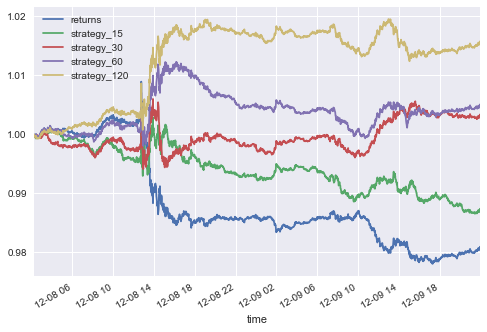

In [5]:
%matplotlib inline
import seaborn as sns; sns.set()

strats = ['returns']

for col in cols:
    strat = 'strategy_%s' % col.split('_')[1] 
    df[strat] = df[col].shift(1) * df['returns']
    strats.append(strat)

df[strats].dropna().cumsum().apply(np.exp).plot()

In [6]:
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest

order = orders.(config['oanda']['account_id'],instrument='EUR_USD', units=100, side='buy',type='market')
class MomentumTrader(PricingStream): 
    def __init__(self, momentum, *args, **kwargs): 
        PricingStream.__init__(self, *args, **kwargs)
        self.ticks = 0 
        self.position = 0
        self.df = pd.DataFrame()
        self.momentum = momentum
        self.units = 100000
    def create_order(self, side, units):
        order = orders(config['oanda']['account_id'], 
            instrument='EUR_USD', units=units, side=side,
            type='market') 
        print('\n', order)
    def on_success(self, data):
        self.ticks += 1
        # print(self.ticks, end=', ')
        # appends the new tick data to the DataFrame object
        self.df = self.df.append(pd.DataFrame(data['tick'],
                                 index=[data['tick']['time']]))
        # transforms the time information to a DatetimeIndex object
        self.df.index = pd.DatetimeIndex(self.df['time'])
        # resamples the data set to a new, homogeneous interval
        dfr = self.df.resample('5s').last()
        # calculates the log returns
        dfr['returns'] = np.log(dfr['ask'] / dfr['ask'].shift(1))
        # derives the positioning according to the momentum strategy
        dfr['position'] = np.sign(dfr['returns'].rolling( 
                                      self.momentum).mean())
        if dfr['position'].ix[-1] == 1:
            # go long
            if self.position == 0:
                self.create_order('buy', self.units)
            elif self.position == -1:
                self.create_order('buy', self.units * 2)
            self.position = 1
        elif dfr['position'].ix[-1] == -1:
            # go short
            if self.position == 0:
                self.create_order('sell', self.units)
            elif self.position == 1:
                self.create_order('sell', self.units * 2)
            self.position = -1
        if self.ticks == 250:
            # close out the position
            if self.position == 1:
                self.create_order('sell', self.units)
            elif self.position == -1:
                self.create_order('buy', self.units)
            self.disconnect()

SyntaxError: invalid syntax (<ipython-input-6-33d6debede06>, line 5)

In [ ]:
mt = MomentumTrader(momentum=12, environment='practice',
                    access_token=config['oanda']['access_token'])

In [ ]:
#response = oanda2.user.get_info()
#print("Response: {} ({})".format(response.status, response.reason))



mt.rates(account_id=config['oanda']['account_id'],
         instruments="EUR_USD,EUR_JPY,US30_USD,DE30_EUR")